In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv("/kaggle/input/forest-fires-regression/forestfires.csv")
df.describe()

/kaggle/input/forest-fires-regression/forestfires.csv


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# 0. Imports
Ignore the following Cell

In [84]:
# ************* Misc. *************
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from tqdm import tqdm
from prettytable import PrettyTable

# ************* Plotting *************
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

# ************* Model Selection *************
import lightgbm as lgb

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostClassifier, Pool

import optuna

# ************* Model Evaluation *************
from sklearn.metrics import mean_squared_error, r2_score


# 1. Data Visualization

# 1.1 Missing (Null) Values

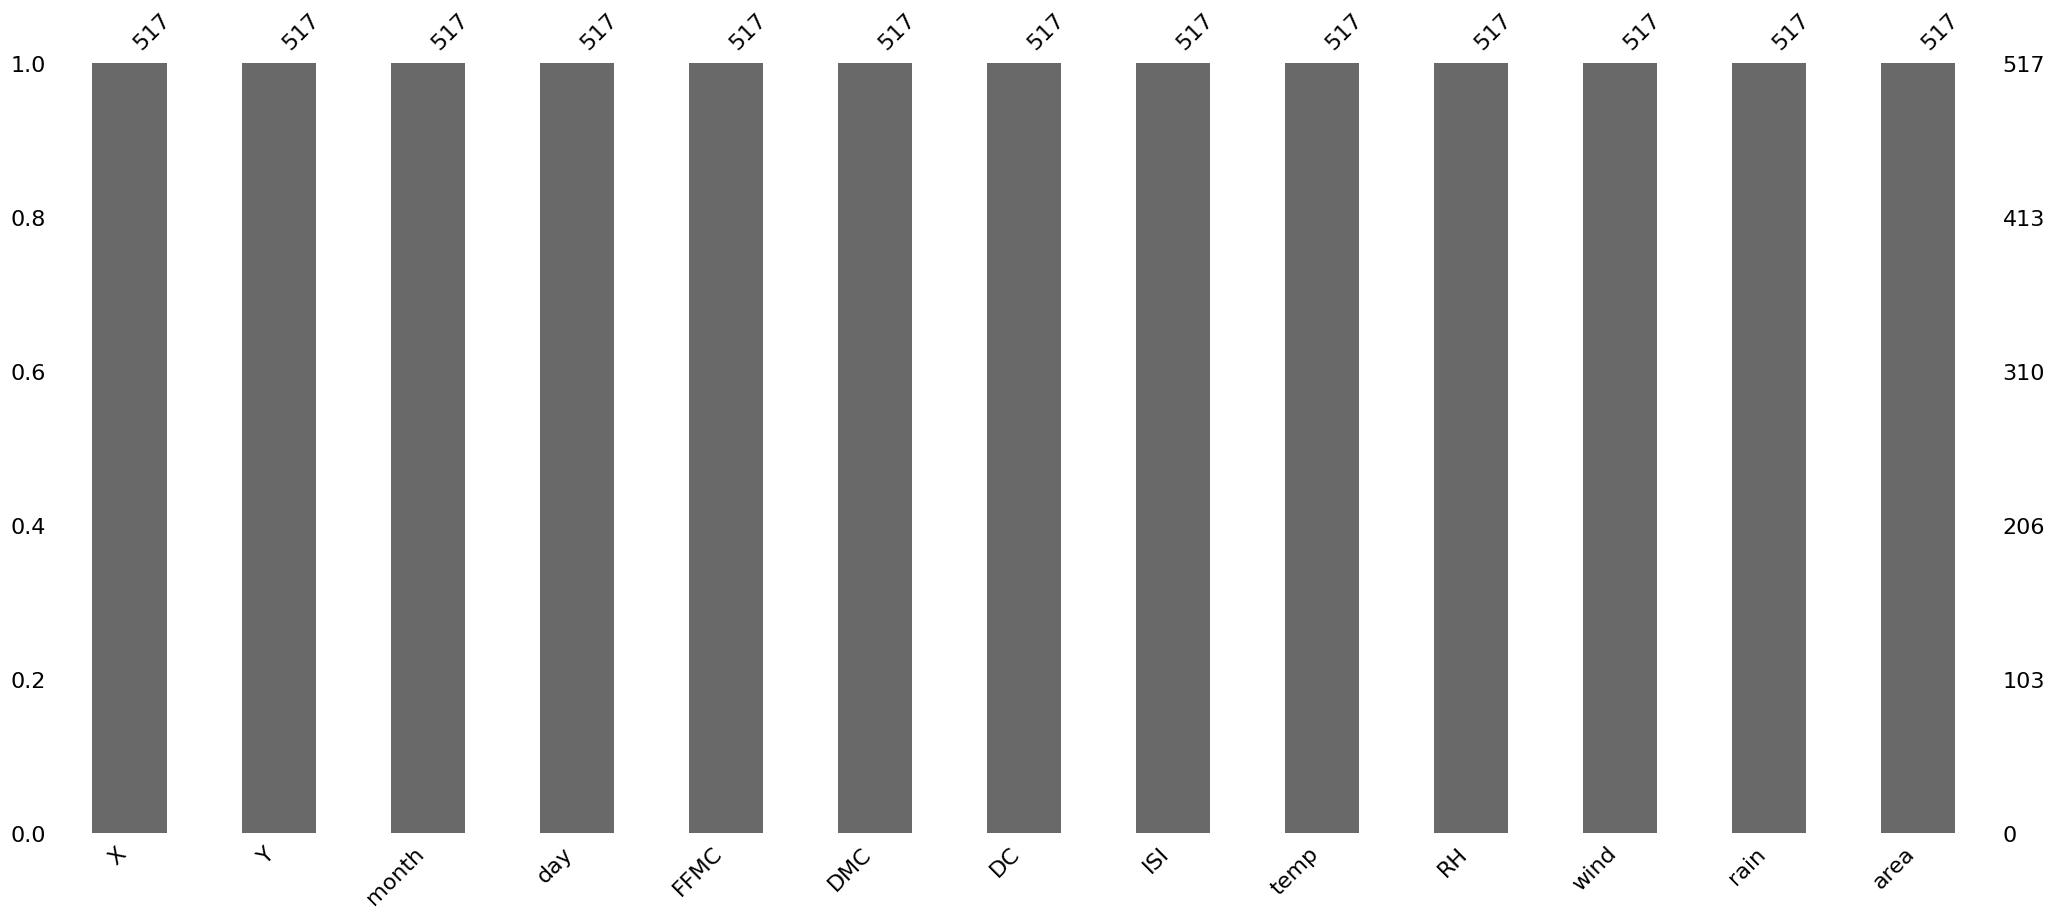

In [85]:
msno.bar(df)
plt.show()

# 1.2 Features and their Data Types

In [86]:
table = PrettyTable()
table.field_names = ['Feature', 'Data Type']

for column in df.columns:
    # Add each feature name and its datatype to the PrettyTable object
    column_dtype = str(df[column].dtype) 
    table.add_row([column, column_dtype])

print(table)

+---------+-----------+
| Feature | Data Type |
+---------+-----------+
|    X    |   int64   |
|    Y    |   int64   |
|  month  |   object  |
|   day   |   object  |
|   FFMC  |  float64  |
|   DMC   |  float64  |
|    DC   |  float64  |
|   ISI   |  float64  |
|   temp  |  float64  |
|    RH   |   int64   |
|   wind  |  float64  |
|   rain  |  float64  |
|   area  |  float64  |
+---------+-----------+


# 1.3 Correlation Matrix

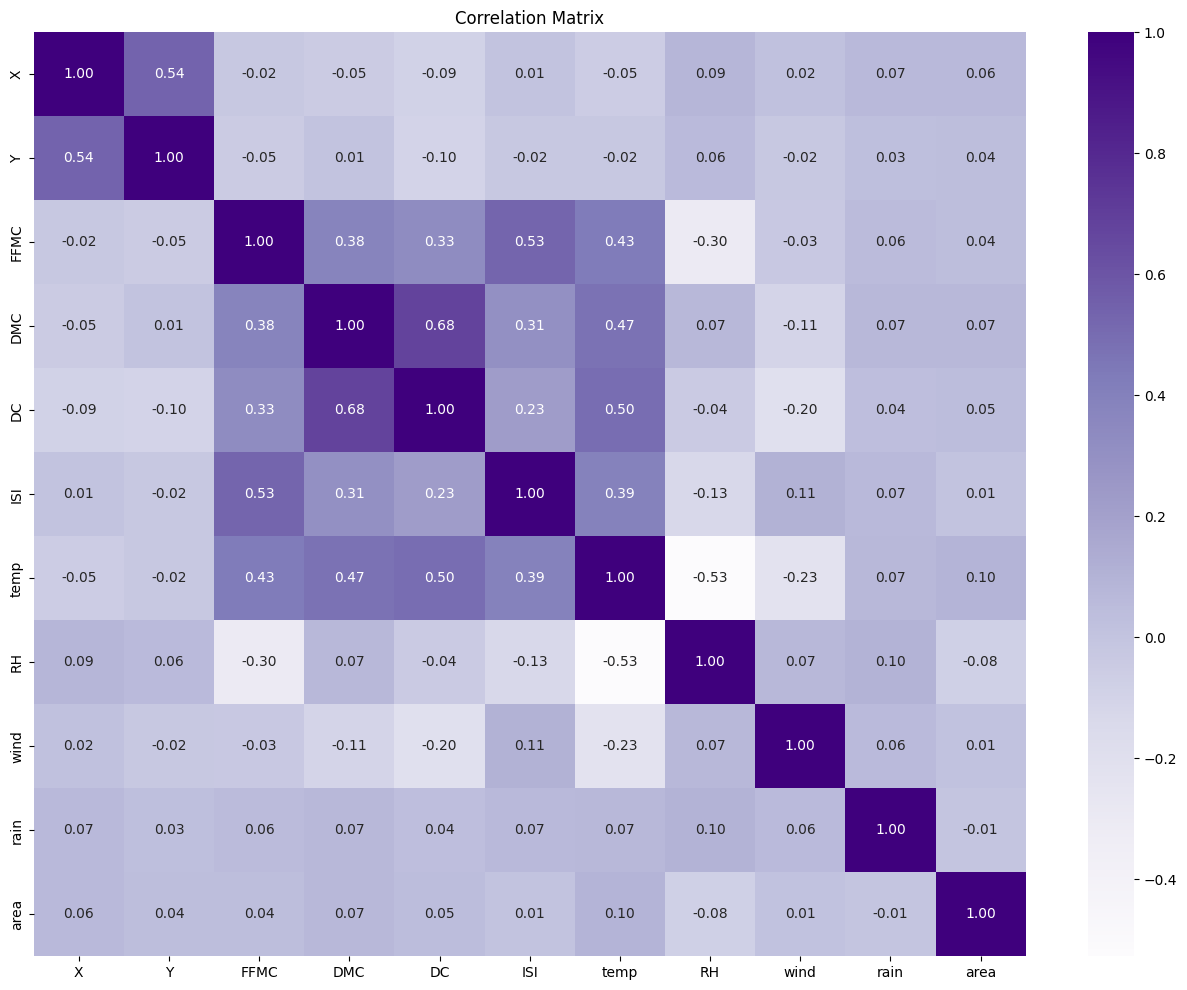

In [87]:
# Filter out non-numerical columns
df_numeric = df.select_dtypes(include=[float, int])

correlation_matrix = df_numeric.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=True, cmap="Purples", fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# 1.4 Effect of Wind on Area

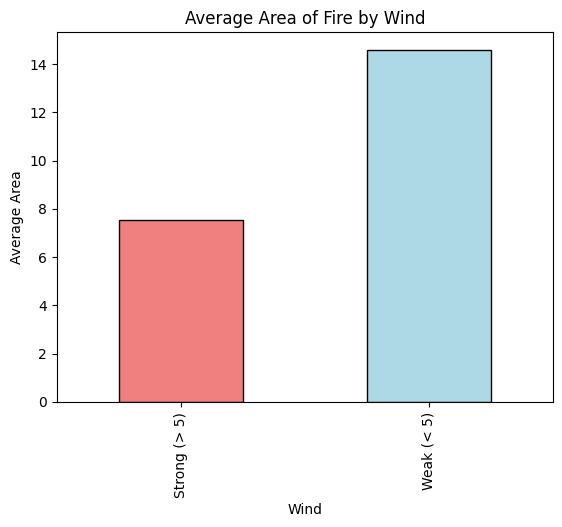

In [88]:
# Categorises the samples by wind column being more or less than 5
df["wind_category"] = df["wind"].apply(lambda x: "Strong (> 5)" if x > 5.0 else "Weak (< 5)")

avg_area = df.groupby("wind_category")["area"].mean() # Get the mean are of each category

avg_area.plot(kind="bar", color=["lightcoral", "lightblue"], edgecolor="black")
plt.xlabel("Wind")
plt.ylabel("Average Area")
plt.title("Average Area of Fire by Wind")
plt.show()

# 1.5 Area Values


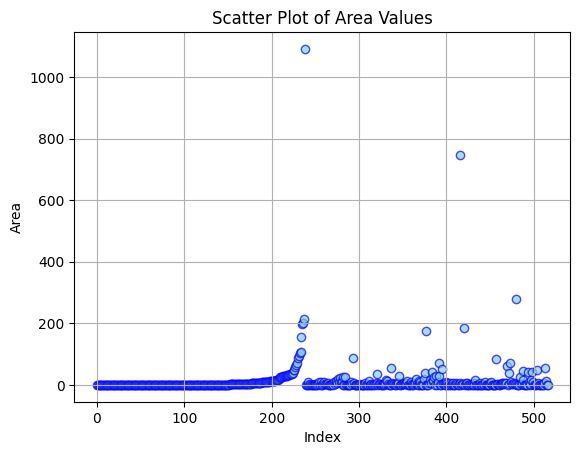

In [89]:
plt.scatter(df.index, df["area"], color='skyblue', alpha=0.7, edgecolor='blue')
plt.xlabel("Index")
plt.ylabel("Area")
plt.title("Scatter Plot of Area Values")
plt.grid(True)
plt.show()

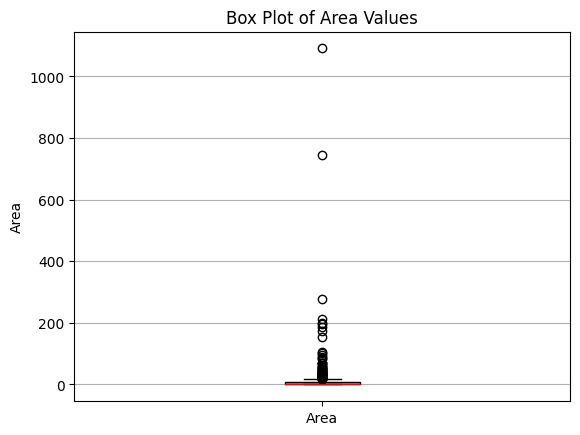

In [90]:
plt.boxplot(df["area"], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
            whiskerprops=dict(color='black'), capprops=dict(color='black'), medianprops=dict(color='red'))

plt.ylabel("Area")
plt.title("Box Plot of Area Values")
plt.xticks([1], ['Area'])
plt.grid(axis='y')
plt.show()

# 2. Feature Engineering/Transformation

# 2.1 Log Transformation and its effects

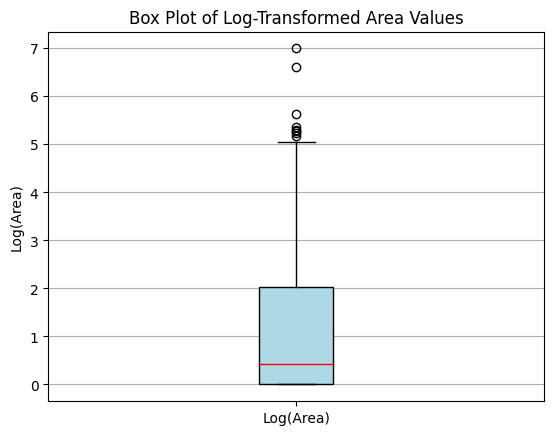

In [91]:
df["log_area"] = np.log(df["area"] + 1)  # Adding 1 to avoid log(0)

plt.boxplot(df["log_area"], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            whiskerprops=dict(color='black'), capprops=dict(color='black'),
            medianprops=dict(color='red'))

plt.ylabel("Log(Area)")
plt.title("Box Plot of Log-Transformed Area Values")
plt.xticks([1], ['Log(Area)'])  # Label the x-axis
plt.grid(axis='y')
plt.show()

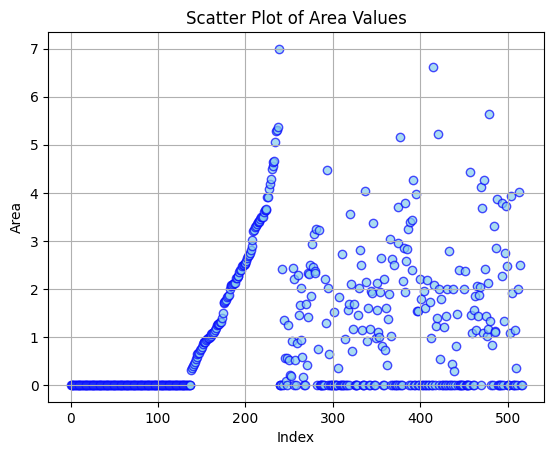

In [92]:
plt.scatter(df.index, df["log_area"], color='skyblue', alpha=0.7, edgecolor='blue')
plt.xlabel("Index")
plt.ylabel("Area")
plt.title("Scatter Plot of Area Values")
plt.grid(True)
plt.show()

# 2.2 Encode the "month" feature

In [93]:
# Initialize the encoder
label_encoder = LabelEncoder()

# Apply label encoding to the "month" column
df["month"] = label_encoder.fit_transform(df["month"])

# 3. Machine Learning

In [94]:
""" 
These are not needed, because 'wind category' and 'day' columns are strings,
# and area is not needed because 'log_area' exists 
"""
df = df.drop(columns=['area', 'wind_category'])
df = df.drop(columns=['day'])

# 3.1 Linear Regression

In [95]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Train test split with 30% for evaluation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_list = []
r2_list = []

def cross_validation(model, X_train, X_test, y_train, y_test):
    # K-Fold Cross-Validation
    print("Beginning K-Fold Cross Validation")
    fold = 0
    for train_index, val_index in kf.split(X_train):
        fold +=1

        X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_kf_train, y_kf_train)

        y_kf_pred = model.predict(X_kf_val)

        mse = mean_squared_error(y_kf_val, y_kf_pred)
        r2 = r2_score(y_kf_val, y_kf_pred)

        # Display results of each fold (rounded to two decimal places)
        print("-"*100) # seperator
        print(f"Fold {fold} results:")
        print(f"\t Mean Squared Error (MSE): {mse:.2f}")
        print(f"\t R-squared (R²): {r2:.2f}")

        mse_list.append(mse)
        r2_list.append(r2)

    # Average metrics over all folds
    avg_mse = np.mean(mse_list)
    avg_r2 = np.mean(r2_list)

    # Show the average results over all folds (rounded to two decimal places)
    print("-"*100) # seperator
    print(f"Average Mean Squared Error (MSE) over all folds: {avg_mse:.2f}")
    print(f"Average R-squared (R²) over all folds: {avg_r2:.2f}")

    test_predictions = model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Show the best results (rounded to two decimal places)
    print("*"*100)
    print(f"Test Set Mean Squared Error (MSE): {test_mse:.2f}")
    print(f"Test Set R-squared (R²): {test_r2:.2f}")
    
cross_validation(model=LinearRegression(), X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Beginning K-Fold Cross Validation
----------------------------------------------------------------------------------------------------
Fold 1 results:
	 Mean Squared Error (MSE): 1.82
	 R-squared (R²): 0.01
----------------------------------------------------------------------------------------------------
Fold 2 results:
	 Mean Squared Error (MSE): 2.03
	 R-squared (R²): -0.04
----------------------------------------------------------------------------------------------------
Fold 3 results:
	 Mean Squared Error (MSE): 2.75
	 R-squared (R²): 0.00
----------------------------------------------------------------------------------------------------
Fold 4 results:
	 Mean Squared Error (MSE): 4.61
	 R-squared (R²): -1.44
----------------------------------------------------------------------------------------------------
Fold 5 results:
	 Mean Squared Error (MSE): 1.43
	 R-squared (R²): -0.10
--------------------------------------------------------------------------------------------------

# 3.2 Random Forests
Need to find the best `n_estimators` parameter. For that, we iterated through 100 models with increasing number of estimators and saved the one with maximum MSE score

In [96]:
mse_max = 999
n_max = 0
r2_max = 0

for n in tqdm(range(1, 100)):
    rf_regressor = RandomForestRegressor(n_estimators=n, random_state=42)
    
    rf_regressor.fit(X_train, y_train)
    y_hat = rf_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)

    if mse<mse_max:
        n_max = n
        mse_max = mse
        r2_max = r2

print(f"ESTIMATORS {n_max}")
print("Mean Squared Error:", mse_max)
print("R^2 Score:", r2_max)

100%|██████████| 99/99 [00:13<00:00,  7.16it/s]

ESTIMATORS 97
Mean Squared Error: 2.0336273104530007
R^2 Score: -0.046738436095147495


We conclude that the best results were achieved via `n_estimators` set to 32

# 3.2.1 Hyperparameter Optimisation
The experiment conducted before is not a great way to find best parameters, so we resort to the library called 'optuna'
This library is used to run 'studies' where different combinations of parameters are tried out (within a given range) to find 
a combination that gives the best results

In [97]:
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 30, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 30)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    # Create the model with the current set of hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_hat = model.predict(X_test)
    
    # Calculate and return MSE as the objective to minimize
    mse = mean_squared_error(y_test, y_hat)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-11-19 17:29:24,084] A new study created in memory with name: no-name-c4fd35e9-4dbf-4478-9bca-4024f8c46585
[I 2024-11-19 17:29:24,277] Trial 0 finished with value: 1.9563731912397238 and parameters: {'n_estimators': 127, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 0 with value: 1.9563731912397238.
[I 2024-11-19 17:29:24,710] Trial 1 finished with value: 1.919520865526955 and parameters: {'n_estimators': 283, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 1.919520865526955.
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[I 2024-11-19 17:29:25,019] Trial 2 fi

Now we get the best parameters

In [98]:
print("Best hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

Best hyperparameters: {'n_estimators': 232, 'max_depth': 48, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best MSE: 1.909107844656296


In [99]:
rf_regressor = RandomForestRegressor(n_estimators=269, min_samples_split=29, max_depth=30, min_samples_leaf=3, max_features='sqrt', random_state=42)

rf_regressor.fit(X_train, y_train)
y_hat = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)

if mse<mse_max:
    n_max = n
    mse_max = mse
    r2_max = r2

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 1.9268320345791006
R^2 Score: 0.008230691962881509


# 3.3 k-Nearest-Neighbors

In [103]:
model = KNeighborsRegressor(n_neighbors=6, weights='uniform', p=2)

model.fit(X_train, y_train)

y_hat = model.predict(X_test)

mse = mean_squared_error(y_test, y_hat)

print(f"Mean Squared Error is --> {mse}")

Mean Squared Error is --> 1.9869685197570834


# 3.3.1 Hyperparameter Optimisation
Now let's see how much we can improve by setting better parameters

In [100]:
def objective(trial):
    # Suggest values for the hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 4)
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)
    
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_hat)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-11-19 17:30:02,624] A new study created in memory with name: no-name-b3982cc3-9dd9-4a3f-bad6-b1e61cfbeedf
[I 2024-11-19 17:30:02,633] Trial 0 finished with value: 2.3257626995293483 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 2.3257626995293483.
[I 2024-11-19 17:30:02,643] Trial 1 finished with value: 1.95811597019364 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 1.95811597019364.
[I 2024-11-19 17:30:02,650] Trial 2 finished with value: 2.0581288831187092 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.95811597019364.
[I 2024-11-19 17:30:02,658] Trial 3 finished with value: 1.9927839528412987 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.95811597019364.
[I 2024-11-19 17:30:02,669] Trial 4 finished with value: 2.01216146784462 and parameters: {'n_neighbors': 12, 'weights': 'uniform',

We get the best performing hyperparameters

In [101]:
print("Best hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

Best hyperparameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1}
Best MSE: 1.9147634648216423


In [102]:
model = KNeighborsRegressor(n_neighbors=7, weights='uniform', p=3)

model.fit(X_train, y_train)

y_hat = model.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 1.9255308527626454
R^2 Score: 0.008900429732742854
